## Keras EfficientNet example
[Link to tutorial](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

Content
1. [AWS BucketSetup](#1.-AWS-Bucket-setup)

In [1]:
%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 72

In [2]:
%pip install --upgrade sagemaker
%pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import sys
import json
import glob
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sagemaker
from sagemaker import get_execution_role, image_uris, model_uris, script_uris, hyperparameters
from sagemaker.s3 import S3Downloader
from sagemaker.utils import name_from_base
from sagemaker.session import Session
from sagemaker.estimator import Estimator
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker import exceptions
from sagemaker.tuner import (
    HyperparameterTuner,
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
)
from botocore.exceptions import ClientError
import tensorflow_datasets as tfds

In [4]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

tf.keras.backend.set_image_data_format('channels_last')
tf.keras.backend.image_data_format()

2022-12-30 19:06:20.184285: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-30 19:06:20.184357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-68-32.eu-west-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-30 19:06:20.186309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'channels_last'

## 1. AWS Bucket setup

In [5]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
# Download data for preprocessing
solution_bucket = "sagemaker-solutions-prod"
solution_name = "sagemaker-defect-detection/1.4.0"

original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_data_prefix = "data/NEU-DET.zip"
original_data = f"{original_bucket}/{original_data_prefix}"
print("original data: ")
S3Downloader.list(original_data)

original data: 


['s3://sagemaker-solutions-prod-eu-west-1/sagemaker-defect-detection/1.4.0/data/NEU-DET.zip']

## Write the output of the model predictions in key with the datetime in it.
I couldn't manage to save the input data in S3. So we load it in again each run.
Probably should have loaded it ecs, unzipped it and copied the output to S3.

In [7]:
topic_prefix = 'keras-examples'
output_files_prefix = name_from_base('efficientnet-classification')


s3_output_location = f"s3://{bucket}/{topic_prefix}/{output_files_prefix}/output"
print(s3_output_location)

s3://sagemaker-eu-west-1-636444261840/keras-examples/efficientnet-classification-2022-12-30-19-06-22-999/output


In [8]:
batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [9]:
## Keras example
# input shape of (224, 224, 3)
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [10]:
model = EfficientNetB0(include_top=False, weights='imagenet')

In [11]:
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

## Stanford dogs

In [12]:
IMG_SIZE = 224

In [13]:


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [14]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

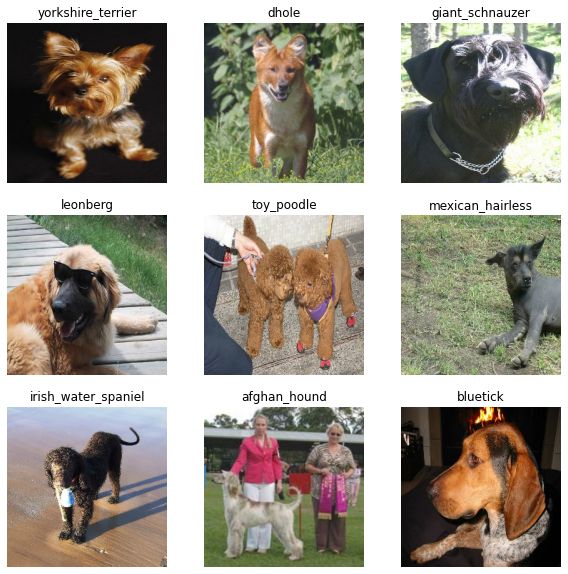

In [15]:
import matplotlib.pyplot as plt


def format_label(label):
    # this is a method on tfds.features.ClassLabel https://www.tensorflow.org/datasets/api_docs/python/tfds/features/ClassLabel#int2str
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [16]:
# data augmentation step
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

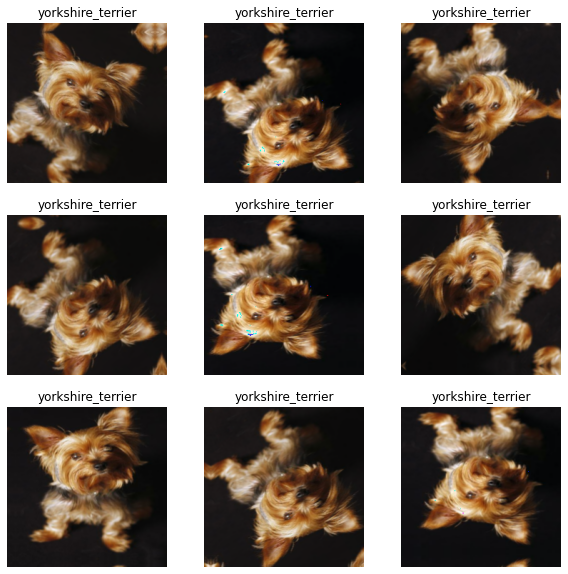

In [17]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # I thnk this is done to add an outer batch dimension.
        # Sometimes tf.nn.conv2d (or the tf network being used requires certain dimensionality)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [18]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [19]:
ds_train

<PrefetchDataset shapes: ((64, 224, 224, 3), (64, 120)), types: (tf.float32, tf.float32)>

In [20]:
ds_test

<BatchDataset shapes: ((64, 224, 224, 3), (64, 120)), types: (tf.float32, tf.float32)>

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________


2022-12-30 19:06:35.271367: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:537] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-12-30 19:06:35.394320: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/40


2022-12-30 19:06:48.170571: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2022-12-30 19:06:48.328459: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2022-12-30 19:06:48.832421: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2022-12-30 19:06:49.150066: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.
